# Linear Regression

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

There are three synthetic datasets that consist of building floor area ($\mathrm{ft}^2$) and yearly electricity consumption ($\mathrm{kBTU}$).<br>
Let's look at the data.

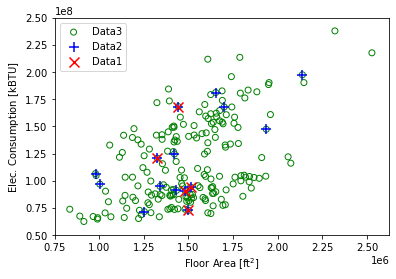

In [16]:
np.random.seed(1234) # for reproducibility
# import dataset
Data3 = pd.read_excel(os.path.join(os.path.dirname('__file__'), '..', 'data', 'Data.xlsx')) # import data

# Data1: subset of Data3
idx_Data1 = np.random.randint(low=0,high=Data3.shape[0],size=5)
Data1 = Data3.loc[idx_Data1,:]

# Data2: subset of Data1
idx_Data2 = np.hstack((idx_Data1, np.random.randint(low=0,high=Data3.shape[0],size=10)))
Data2 = Data3.loc[idx_Data2,:]

# scatter plots
plt.scatter(Data3['Area [sq ft]'], Data3['Elec [kBTU]'], facecolors='None', edgecolors='green', label='Data3')
plt.scatter(Data2['Area [sq ft]'], Data2['Elec [kBTU]'], marker='+', c='blue', s=100, label='Data2')
plt.scatter(Data1['Area [sq ft]'], Data1['Elec [kBTU]'], marker='x', c='red', s=100, label='Data1')
plt.xlabel('Floor Area [$\mathrm{ft}^2$]')
plt.ylabel('Elec. Consumption [$\mathrm{kBTU}$]')
plt.ylim(0.5e+8, 2.5e+8)
plt.xlim(0.75e+6, 2.625e+6)
plt.legend()
plt.show()

Q. Develop linear regression models for ***Data1***, ***Data2***, and ***Data3*** with 'scikit learn' and 'PyMC'. Visualize the models. Think about (i) the goodness of the models; (ii) differences between the models.

Let's preprocess data before developing models. You can use preprocess tools in ***scikit learn*** package (e.g., StandardScaler). Transform is not needed this time.<br>
By the way, [***scikit learn***](https://scikit-learn.org/stable/) is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities.

In [20]:
from sklearn import preprocessing

In [21]:
# Sub-dataset
X1 = Data1['Area [sq ft]'].values[:,None]
Y1 = Data1['Elec [kBTU]'].values[:,None]
Scale_X1 = preprocessing.StandardScaler() # StandardScaler for X1
X1_scaled = Scale_X1.fit_transform(X1) # fit the StandardScaler and transform X1
Scale_Y1 = preprocessing.StandardScaler() # StandardScaler for Y1
Y1_scaled = Scale_Y1.fit_transform(Y1) # fit the StandardScaler and transform Y1

# Data 2
X2 = Data2['Area [sq ft]'].values[:,None]
Y2 = Data2['Elec [kBTU]'].values[:,None]
Scale_X2 = preprocessing.StandardScaler() # StandardScaler for X2
X2_scaled = Scale_X2.fit_transform(X2) # fit the StandardScaler and transform X2
Scale_Y2 = preprocessing.StandardScaler() # StandardScaler for Y2
Y2_scaled = Scale_Y2.fit_transform(Y2) # fit the StandardScaler and transform Y2

# Dataset
X3 = Data3['Area [sq ft]'].values[:,None]
Y3 = Data3['Elec [kBTU]'].values[:,None]
Scale_X3 = preprocessing.StandardScaler() # StandardScaler for X3
X3_scaled = Scale_X3.fit_transform(X3) # fit the StandardScaler and transform X3
Scale_Y3 = preprocessing.StandardScaler() # StandardScaler for Y3
Y3_scaled = Scale_Y3.fit_transform(Y3) # fit the StandardScaler and transform Y3

# points to visualize the models
X_plot = np.linspace(X3.min(), X3.max(),100)[:,None]
X1_plot_scaled = Scale_X1.transform(X_plot)
X2_plot_scaled = Scale_X2.transform(X_plot)
X3_plot_scaled = Scale_X3.transform(X_plot)

## 1. Maximum likelihood (least-square) solution

We use ***linear_model*** in ***scikit learn*** package to train linear models

In [22]:
from sklearn import linear_model

### Linear regression models

In [23]:
# train a linear regression model
Linear1_MLE = linear_model.LinearRegression()
Linear1_MLE.fit(X=X1_scaled,y=Y1_scaled) # train
Y1_plot_scaled = Linear1_MLE.predict(X1_plot_scaled) # predict
Y1_plot = Scale_Y1.inverse_transform(Y1_plot_scaled) # inverse transform

In [7]:
# train a linear regression model
Linear2_MLE = linear_model.LinearRegression()
Linear2_MLE.fit(X=X2_scaled,y=Y2_scaled) # train
Y2_plot_scaled = Linear2_MLE.predict(X2_plot_scaled) # predict
Y2_plot = Scale_Y2.inverse_transform(Y2_plot_scaled) # inverse transform

In [8]:
# train a linear regression model
Linear3_MLE = linear_model.LinearRegression()
Linear3_MLE.fit(X=X3_scaled,y=Y3_scaled) # train
Y3_plot_scaled = Linear3_MLE.predict(X3_plot_scaled) # predict
Y3_plot = Scale_Y3.inverse_transform(Y3_plot_scaled) # inverse transform

### Visualization

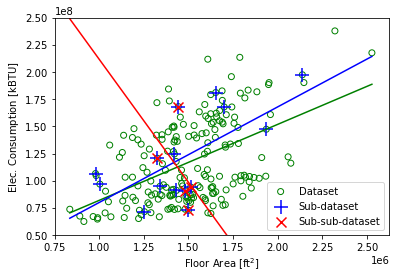

In [24]:
# visualization
plt.scatter(Data3['Area [sq ft]'], Data3['Elec [kBTU]'], facecolors='None', edgecolors='green', label='Dataset')
plt.scatter(Data2['Area [sq ft]'], Data2['Elec [kBTU]'], marker='+', c='b', s=200, label='Sub-dataset')
plt.scatter(Data1['Area [sq ft]'], Data1['Elec [kBTU]'], marker='x', c='r', s=100, label='Sub-sub-dataset')

plt.xlabel('Floor Area [$\mathrm{ft}^2$]')
plt.ylabel('Elec. Consumption [$\mathrm{kBTU}$]')
plt.plot(X_plot, Y3_plot, 'g')
plt.plot(X_plot, Y2_plot, 'b')
plt.plot(X_plot, Y1_plot, 'r')
plt.ylim(0.5e+8,2.5e+8)
plt.xlim(0.75e+6, 2.625e+6)
plt.legend()
plt.show()

## 2. Bayesian solution

We use PyMC3 to train Bayesian linear regression models. [***PyMC3***](https://docs.pymc.io/en/stable/) is a probabilistic programming package for Python that allows users to fit Bayesian models using a variety of numerical methods, most notably Markov chain Monte Carlo (MCMC) and variational inference (VI).

In [10]:
import pymc3 as pm
import theano.tensor as T
import theano
theano.config.compute_test_value='ignore'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [39]:
class Bayesian_LinearReg(object):
    def __init__(self, features, t_Y):
        self.features = features
        self.t_Y = t_Y
        
    # your model structure
    def make_model(self):        
        self.Model = pm.Model()
        with self.Model:
            # prior
#             self.w1 = pm.Exponential('w1',lam=0.1)
#             self.w2 = pm.Normal('w2', mu=0., sd=10.)
#             self.w = pm.Deterministic('w',T.stack((self.w1,self.w2)))
            self.w = pm.Normal('w', mu=0., sd=10.,shape=2)
            self.sigma = pm.Exponential('sigma',lam=0.1)

            # likelihood
            self.mu = T.dot(self.features, self.w)
            self.y_obs = pm.Normal('y_obs', mu=self.mu, sd=self.sigma, observed=self.t_Y)
    
    # training your model
    def get_sample(self):
        # draw samples
        with self.Model:
            step = pm.Metropolis() # Metropolis–Hastings algorithm (https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)
                                   # A traditional MCMC technique used for Bayesian inference.
                                   # It needs a lot of samples.
            self.samples = pm.sample(draws=100000,tune=100000, step=step, chains=1) # we draw 100000 samples after 100000 samples for tuning.
        # plot the trace to check the MCMC result
        pm.traceplot(self.samples)
        plt.show()
        return self.samples
    
    def plot_p_w(self):
        self.w_samples = self.samples['w'][::100] # select 1000 samples out of the 100000 samples (thinning)
        
        # sample distribution representing p(w|data)
        fig,ax=plt.subplots(2,2, figsize=(8,8))
        ax[0,0].hist(self.w_samples[:,0], bins=30, color='b')
        ax[0,0].set_title('$w_1$', fontsize=13)
        ax[0,0].set_xlim(-6,6)
        
        ax[1,1].hist(self.w_samples[:,1], bins=30, color='b')
        ax[1,1].set_title('$w_2$', fontsize=13)
        ax[1,1].set_xlim(-6,6)
        
        ax[1,0].scatter(self.w_samples[:,0],self.w_samples[:,1], facecolors='None', edgecolors='b')
        ax[1,0].set_xlabel('$w_1$', fontsize=13)
        ax[1,0].set_ylabel('$w_2$', fontsize=13)
        ax[1,0].set_xlim(-6,6)
        ax[1,0].set_ylim(-6,6)
        
        ax[0,1].axis('off')
        
        plt.show()
        
    def predict(self, X):
        Y_samples = np.dot(np.concatenate((X, np.ones_like(X)),axis=1),self.w_samples.T)
        Y_med = np.median(Y_samples,axis=1)
        Y_u = np.percentile(Y_samples,axis=1,q=97.5)
        Y_l = np.percentile(Y_samples,axis=1,q=2.5)
        return Y_med, Y_u, Y_l

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_38780/1600291598.py:28: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.samples = pm.sample(draws=100000,tune=100000, step=step, chains=1) # we draw 100000 samples after 100000 samples for tuning.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [w]


Sampling 1 chain for 100_000 tune and 100_000 draw iterations (100_000 + 100_000 draws total) took 64 seconds.
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (100000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_38780/1600291598.py:30: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(self.samples)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful 

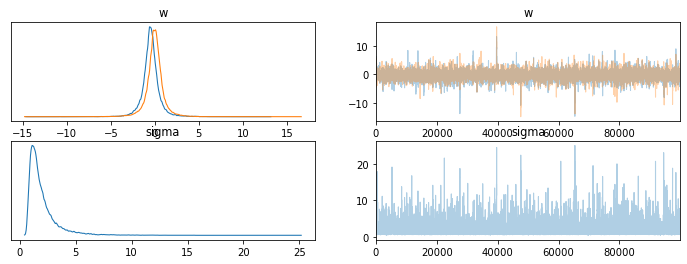

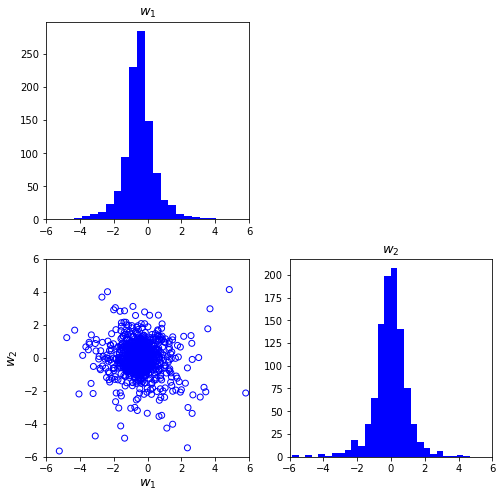

In [40]:
# input and output for Data 1
t_X1 = T.constant(X1_scaled)
t_Y1 = T.constant(Y1_scaled.flatten())
features_data1 = T.concatenate((t_X1,T.ones_like(t_X1)),axis=1)

# model for Data1
Model_Data1 = Bayesian_LinearReg(features=features_data1, t_Y=t_Y1)
Model_Data1.make_model()
Model_Data1.get_sample()
Model_Data1.plot_p_w()

# predict
Y1_med_scaled, Y1_u_scaled, Y1_l_scaled = [Scale_Y1.inverse_transform(y[:,None]) for y in Model_Data1.predict(X=X1_plot_scaled)]

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_38780/1600291598.py:28: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.samples = pm.sample(draws=100000,tune=100000, step=step, chains=1) # we draw 100000 samples after 100000 samples for tuning.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [w]


Sampling 1 chain for 100_000 tune and 100_000 draw iterations (100_000 + 100_000 draws total) took 62 seconds.
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (100000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_38780/1600291598.py:30: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(self.samples)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful 

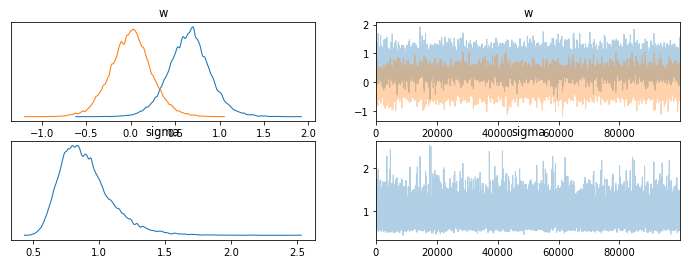

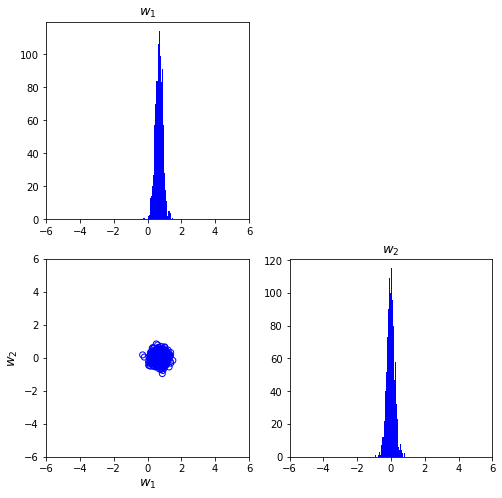

In [41]:
# input and output
t_X2 = T.constant(X2_scaled)
t_Y2 = T.constant(Y2_scaled.flatten())
features_data2 = T.concatenate((t_X2,T.ones_like(t_X2)),axis=1)

# model
Model_Data2 = Bayesian_LinearReg(features=features_data2, t_Y=t_Y2)
Model_Data2.make_model()
Model_Data2.get_sample()
Model_Data2.plot_p_w()

# predict
Y2_med_scaled, Y2_u_scaled, Y2_l_scaled = [Scale_Y2.inverse_transform(y[:,None]) for y in Model_Data2.predict(X=X2_plot_scaled)]

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_38780/1600291598.py:28: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.samples = pm.sample(draws=100000,tune=100000, step=step, chains=1) # we draw 100000 samples after 100000 samples for tuning.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [w]


Sampling 1 chain for 100_000 tune and 100_000 draw iterations (100_000 + 100_000 draws total) took 64 seconds.
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (100000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_38780/1600291598.py:30: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(self.samples)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful 

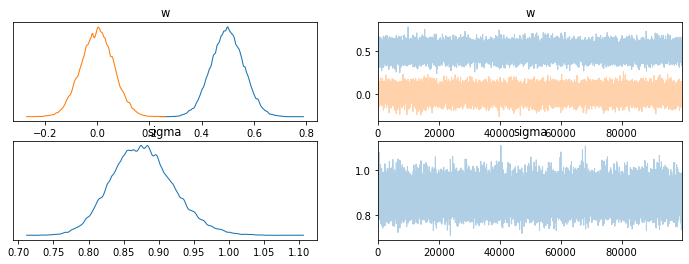

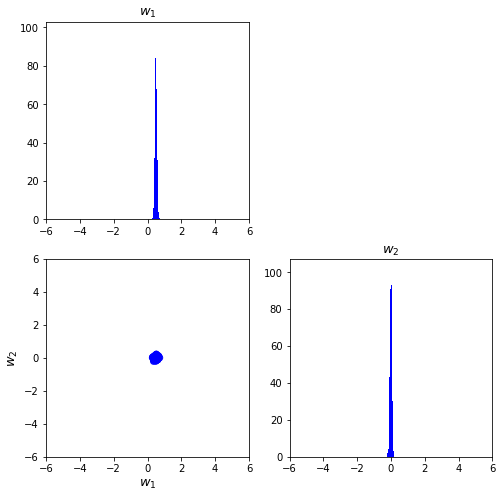

In [42]:
# input and output
t_X3 = T.constant(X3_scaled)
t_Y3 = T.constant(Y3_scaled.flatten())
features_data3 = T.concatenate((t_X3,T.ones_like(t_X3)),axis=1)

# model
Model_Data3 = Bayesian_LinearReg(features=features_data3, t_Y=t_Y3)
Model_Data3.make_model()
Model_Data3.get_sample()
Model_Data3.plot_p_w()

# predict
Y3_med_scaled, Y3_u_scaled, Y3_l_scaled = \
            [Scale_Y3.inverse_transform(y[:,None]) for y in Model_Data3.predict(X=X3_plot_scaled)]

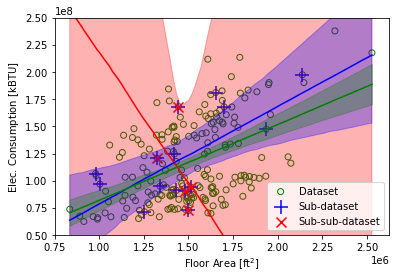

In [44]:
# visualization
plt.scatter(Data3['Area [sq ft]'], Data3['Elec [kBTU]'], facecolors='None', edgecolors='green', label='Dataset')
plt.scatter(Data2['Area [sq ft]'], Data2['Elec [kBTU]'], marker='+', c='b', s=200, label='Sub-dataset')
plt.scatter(Data1['Area [sq ft]'], Data1['Elec [kBTU]'], marker='x', c='r', s=100, label='Sub-sub-dataset')
plt.xlabel('Floor Area [$\mathrm{ft}^2$]')
plt.ylabel('Elec. Consumption [$\mathrm{kBTU}$]')

plt.plot(X_plot, Y1_med_scaled.flatten(), 'r')
plt.fill_between(X_plot.flatten(), Y1_l_scaled.flatten(), Y1_u_scaled.flatten(), alpha=0.3, color='r')
plt.plot(X_plot, Y2_med_scaled.flatten(), 'b')
plt.fill_between(X_plot.flatten(), Y2_l_scaled.flatten(), Y2_u_scaled.flatten(), alpha=0.3, color='b')
plt.plot(X_plot, Y3_med_scaled, 'g')
plt.fill_between(X_plot.flatten(), Y3_l_scaled.flatten(), Y3_u_scaled.flatten(), alpha=0.3, color='g')

plt.ylim(0.5e+8,2.5e+8)
plt.xlim(0.75e+6, 2.625e+6)
plt.legend()
plt.show()